# Descriptive Analysis

In [3]:
"""
Author: Surabhi S Nath
Description: This script implements descriptive analysis on the data.
"""

'\nAuthor: Surabhi S Nath\nDescription: This script implements descriptive analysis on the data.\n'

In [4]:
# Imports
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 10000)
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(font_scale=1.8, font="serif")
from scipy import stats

In [5]:
# Define variables
path = "../data/"               # data path
patterns_path = "../"           # patterns path
num_patterns = 216              # total number of patterns
num_trials = 60                 # number of trial per participant

# Load files
pattern_to_num = pickle.load(open("utils/pattern_to_num.pk", 'rb')) # maps pattern name to pattern num
num_to_pattern = {v: k for k, v in pattern_to_num.items()}          # maps pattern num to pattern name
info = pd.read_csv(path + "info.csv")                               # stores participant demographic data
pattern_stats = pd.read_csv("utils/pattern_stats.csv")              # stores statistics for each pattern - pattern num, set and all measures
df = pd.read_csv("utils/stat_analysis.csv")                         # dataframe storing allparticipant data - trials, patterns (with stats), ratings

## Filter Participants

In [6]:
# Remove participants who failed all attention checks
all_attention_failed = list(info[info["num_failed_attention_checks"] == info["num_attention_checks"]]["subject"])
df = df[~df["subject"].isin(all_attention_failed)]

In [7]:
# Read data and save to arrays
pattern_complexity_ratings = [[]] * num_patterns
pattern_beauty_ratings = [[]] * num_patterns
subject_complexity_responses = []
subject_beauty_responses = []
subject_patterns = []

# Save repeats info - first, second value separately for correlations, SD values, differences

# first, second value separately
firstrepeat_complexity = []
secondrepeat_complexity = []
firstrepeat_beauty = []
secondrepeat_beauty = []

# SD values
participant_repeats_complexity_sd = []
participant_repeats_beauty_sd = []

# differences
complexity_diff_in_repeats = []
beauty_diff_in_repeats = []
repeats_distances = []

for i, file in enumerate(np.sort(os.listdir(path))):
    if file.split("_")[0] != "data":
        continue
    if file.split("_")[1] in all_attention_failed:
        continue
    
    pdf = pd.read_csv(os.path.join(path, file))

    # Repeats
    repeats = pdf[pdf["is_repeated"] == True]

    complexity_repeats = repeats.sort_values(by='pattern')["complexity_response"].to_numpy()
    beauty_repeats = repeats.sort_values(by='pattern')["beauty_response"].to_numpy()

    # store first rating and second rating separately
    firstrepeat_complexity.append(complexity_repeats[::2])
    secondrepeat_complexity.append(complexity_repeats[1::2])
    firstrepeat_beauty.append(beauty_repeats[::2])
    secondrepeat_beauty.append(beauty_repeats[1::2])

    # calculate mean standard deviation of repeats
    participant_repeats_complexity_sd.append(np.mean(repeats.groupby('pattern').std()['complexity_response'].to_numpy()))
    participant_repeats_beauty_sd.append(np.mean(repeats.groupby('pattern').std()['beauty_response'].to_numpy()))

    # Calculate difference in repeats
    repeats_diff = repeats.sort_values(by='pattern').diff()
    repeats_diff = repeats_diff[repeats_diff['pattern'] == 0]
    complexity_diff_in_repeats.append(repeats_diff['complexity_response'].abs().to_numpy())
    beauty_diff_in_repeats.append(repeats_diff['beauty_response'].abs().to_numpy())
    repeats_distances.append(repeats_diff['trial'].abs().to_numpy())


    # Record responses and pattern list
    beauty_responses = pdf["beauty_response"].to_numpy()
    subject_beauty_responses.append(beauty_responses)
    complexity_responses = pdf["complexity_response"].to_numpy()
    subject_complexity_responses.append(complexity_responses)
    patterns = pdf["pattern"].to_numpy()
    subject_patterns.append(patterns)
    
    # Record responses per pattern
    for i,p in enumerate(patterns):
        pattern_complexity_ratings[p-1].append(complexity_responses[i])
        pattern_beauty_ratings[p-1].append(beauty_responses[i])

## Correlations - Figure 4, Figure AIII.1

In [8]:
# Code borrowed from https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/ (a mathematical explanation is also provided)
def pearsonr_ci(x, y, alpha=0.05):
    """ 
    Calculate Pearson correlation along with the confidence interval using scipy and numpy
    
    Parameters:
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    
    Returns:
      r : float
        Pearson's correlation coefficient
      pval : float
        The corresponding p value
      lo, hi : float
        The lower and upper bound of confidence intervals
      df: integer
        Degrees of freedom
    """
    
    assert len(x) == len(y)

    df = len(x) - 2
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi, df

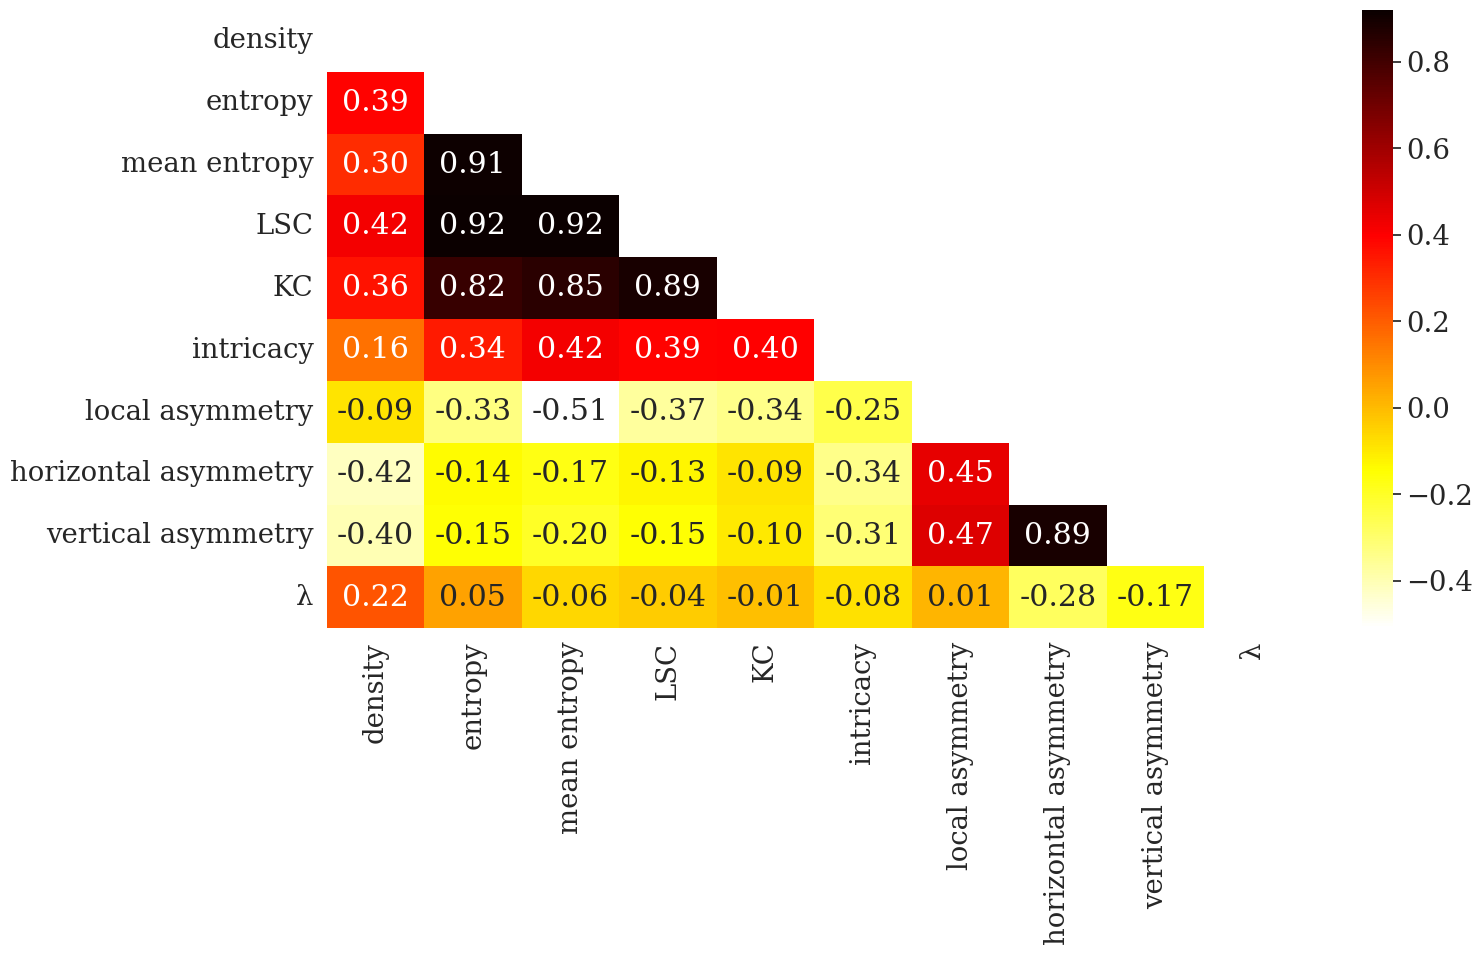

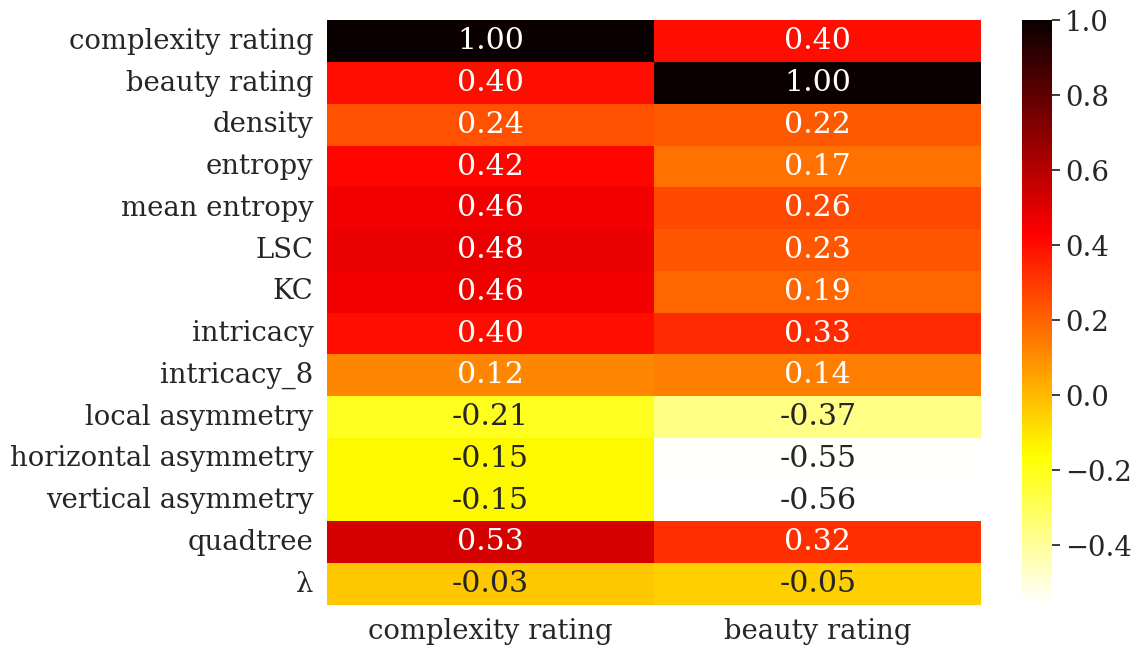

In [9]:
df_corr = df[["complexity_rating", "beauty_rating", "density", "entropy", "mean_entropy", "LSC", "KC", "intricacy_4", "intricacy_8", "local_asymm",	"Hasymm",	"Vasymm", "quadtree", "num_active_rules"]]

# Uncomment to print significances, CI:
'''
for c1 in df_corr.columns:
    for c2 in df_corr.columns:
        print(c1, "\t", c2)
        corr, sig, cil, cih, df = pearsonr_ci(df_corr[c1].values, df_corr[c2].values)
        print(np.round(corr,2), "\t", np.round(sig, 3), "\t", np.round(cil, 2), "\t", np.round(cih, 2))
'''

# Rename columns for figures
df_corr = df_corr.rename(columns={  
                                "complexity_rating": "complexity rating",
                                "beauty_rating": "beauty rating",
                                "mean_entropy": "mean entropy",
                                "intricacy_4": "intricacy",
                                "local_asymm": "local asymmetry",
                                "Hasymm": "horizontal asymmetry",
                                "Vasymm": "vertical asymmetry",
                                "num_active_rules": "\u03BB"
                                })

# Evaluate Pearson correlations
df_corr = df_corr.corr(method='pearson').round(decimals=2)

# Figure 4
df_corr_measures = df_corr.drop(['complexity rating', 'beauty rating', 'intricacy_8', 'quadtree'], axis=1).drop(['complexity rating', 'beauty rating', 'intricacy_8', 'quadtree'], axis=0)  # dropping ratings columns since these are correlations only between measures, 
                                                                                                                                                                                            # dropping intricacy_8 and quadtree since they are introduced later in the appendix and not part of main paper analyses
plt.figure(figsize=(16,10))
matrix = np.triu(df_corr_measures)
ax = sns.heatmap(df_corr_measures, annot=True, fmt=".2f", cmap="hot_r", mask=matrix)
ax.set_facecolor('white')
plt.tight_layout()
plt.savefig("plots/Figure_4_correlations.png")  # note that this plat displays all correlations irrespective of significance (use the pearsonr_ci function to get significances and CIs). 
                                                # Figure 4 in the paper is the updated plot with only significant correlations displayed.
plt.show()

# Figure AIII.1
df_corr_ratings = df_corr[["complexity rating", "beauty rating"]]
plt.figure(figsize=(12,7))
ax = sns.heatmap(df_corr_ratings, annot=True, fmt=".2f", cmap="hot_r")
plt.tight_layout()
plt.savefig("plots/Figure_AIII_1_correlations.png")
plt.show()

## Participant Qualitative Open-ended answers

In [10]:
# Collect open-ended responses for the 4 questions
# This table is summarised in Section 2.3, part 5 Analysis, paragraph 2 in the paper
open_ended_answers = pd.DataFrame({"Complexity Startegy": info["complexity_strategy"],
                                  "Beauty Strategy": info["beauty_strategy"], 
                                  "Most Complex": info["most_complex"], 
                                  "Most beautiful": info["most_beautiful"]})
open_ended_answers

,Complexity Startegy,Beauty Strategy,Most Complex,Most beautiful
0,Placement/ratio of black and white squares,Intuition,The ones that would be hardest for me to replicate -- the randomest ones.,"I think I tended to think the beautiful ones were symmetrical. They reminded me of an old-fashioned quilt or cross-stitch, kind of a folk sort of beauty, which is ironic since they were computer-generated. \nI think I also thought ones were beautiful where I could ""see"" a scene/image in the design that wasn't there"
1,"The more content and the more it was arranged in a pattern, I rated it more complex.",I rated it by how appealing it looks.,The most intricate ones.,The ones that have an attractive design.
2,Intricacy - more like a feeling.,If I liked it or not,Messy but balanced,"Not really sure, I do know I don't like the ones with the Purina symbol in the middle."
3,"The less structure present, in some cases, the more complexity. However, extreme levels of structures also indicated complexity to me as well.","The strategy for beauty was more related to contrast, and design aesthetic. Some designs were more beautiful just because, it's very hard to describe why some were more than others, it felt very impulsive at times.","Patterns that had a deliberate design, or were extremely chaotic or extremely symmetrical.","More often than not, simple was beauty, or extremely well-done symmetry was beauty to me as well."
4,"ability to copy/recall, less repeating while maintaining some form ie not random but might look that way",narrow objective societal aesthetic (which includes me) + wide subjective personal aesthetic,"least repetition while maintaining form, varying form types in single pattern",emotive. dark but not dirty. pretty but unique. (one looked like Klimt's the kiss with a little heart next to it!)
...,...,...,...,...
75,No strategy,No strategy,Ametric,None specifically
76,The ease of pattern or symmetry.,Abstract ideas!,Patterns that wee abstract and lacked symmetry.,The very abstract patterns
77,The more detail an image had the higher the complexity.,Mainly by how a symmetrical they appeared and the balance between black and white.,Patterns with many scattered dots throughout the image.,"Images which were framed, such as a framed cross."
78,"mainly how predictable a pattern was, along with how difficult it would be to make it.","mainly symmetry, but also if it reminded me of something or was satisfying in some other way - to me at least","the chaotic ones, as well as the ones that looked the fullest","the symmetrical ones that I could imagine side by side as tiles, looking nice when multiplied and set next to each other"


## Average Ratings Analysis - Figure AIII.5, AIII.6

### Average Beauty vs Average Complexity Plot - Figure AIII.5

In [11]:
# get patternwise mean and variance
df_patternwisemean = df.groupby("pattern").mean()
df_patternwisesd = df.groupby("pattern").std()

# assign entropy bin based on entropy of means
percentile_33 = np.sort(df_patternwisemean["entropy"])[num_patterns//3]
percentile_66 = np.sort(df_patternwisemean["entropy"])[(num_patterns//3) * 2]
bins_entropy = [0, percentile_33, percentile_66, np.inf]
names_entropy = ['low', 'medium', 'high']
df_patternwisemean["entropy_bin"] = pd.cut(df_patternwisemean["entropy"], bins_entropy, labels=names_entropy)

# assign symmetry bin based on Hasymm and Vasymm
def get_symm_bin(row):
    if row["Hasymm"] + row["Vasymm"] == 0:
        return "full symmetry"
    if row["Hasymm"] * row["Vasymm"] == 0:
        return "unidirection symmetry"
    return "partial/full asymmetry"
df_patternwisemean["symmetry_bin"] = df_patternwisemean.apply(lambda row: get_symm_bin(row), axis=1)

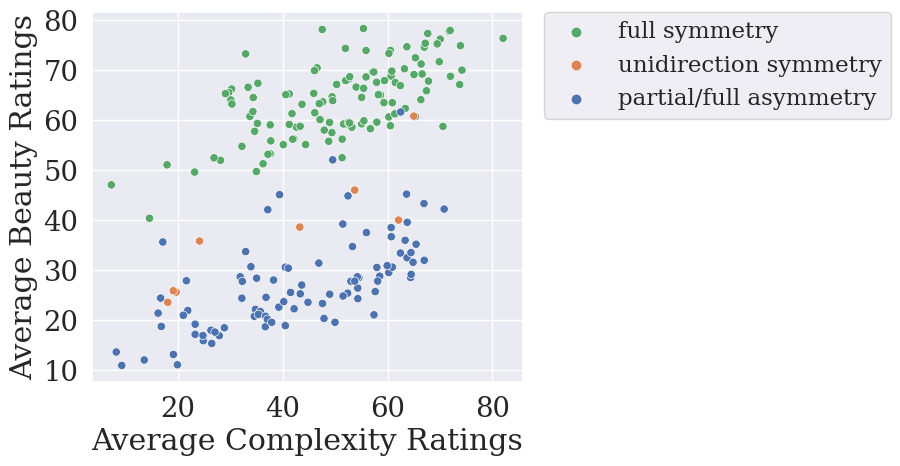

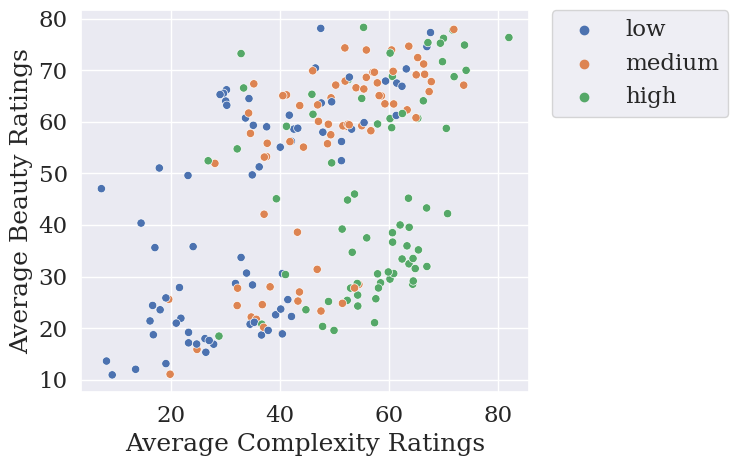

In [12]:
# Plot
# Figure AIII.5(A)
plt.figure(figsize=(9.5,5))
sns.scatterplot(data=df_patternwisemean, x='complexity_rating', y='beauty_rating', hue='symmetry_bin')
plt.xlabel("Average Complexity Ratings")
plt.ylabel("Average Beauty Ratings")
sns.set(font_scale=1.5, font="serif")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("plots/Figure_AIII_5A_subjCvsB_symmetry.png", dpi=700)
plt.show()

# Figure AIII.5(B)
plt.figure(figsize=(7.8,5))
sns.scatterplot(data=df_patternwisemean, x='complexity_rating', y='beauty_rating', hue='entropy_bin')
plt.xlabel("Average Complexity Ratings")
plt.ylabel("Average Beauty Ratings")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("plots/Figure_AIII_5B_subjCvsB_entropyofmeans.png", dpi=700)
plt.show()

### GMM Analysis on Average ratings - Figure AIII.6

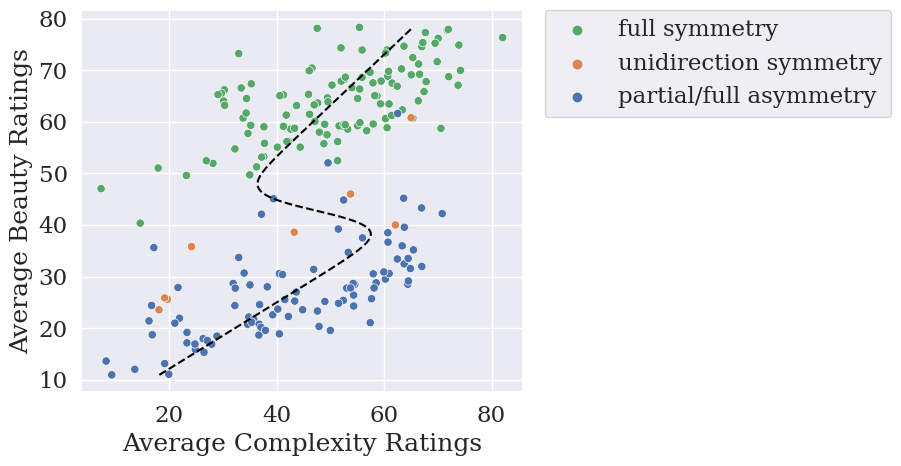

In [13]:
# Fit GMM on average complexity ratings vs average beauty ratings coloured by symmetry
# rc={'axes.facecolor':'white'}

from sklearn.model_selection import train_test_split
from gmr import GMM

indices = np.random.permutation(np.arange(num_patterns))    # shuffle mean pattern complexity and mean pattern beauty values with the same indices
X = df_patternwisemean["complexity_rating"].values.reshape(-1, 1)[indices]
y = df_patternwisemean["beauty_rating"].values.reshape(-1, 1)[indices]
X_test = X[:num_patterns//4,:]  # use one-fourth of the data as test set
y_test = y[:num_patterns//4,:]
X_train = X[num_patterns//4:,:] # use three-fourth of the data as train set
y_train = y[num_patterns//4:,:]

data = np.concatenate([X_train, y_train], 1)

# 2 components for the bimodality
gmm = GMM(n_components=2, random_state=0)
gmm.from_samples(data)

# predictions on train data
data = np.linspace(np.min(y_train), np.max(y_train), 1000).reshape(-1, 1)
preds_train = gmm.predict([1], data)

# Figure AIII.6
plt.figure(figsize=(9.5,5))
sns.scatterplot(data=df_patternwisemean, x='complexity_rating', y='beauty_rating', hue='symmetry_bin')
plt.plot(preds_train, data, c = "black", linestyle='dashed')
plt.xlabel("Average Complexity Ratings")
plt.ylabel("Average Beauty Ratings")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("plots/Figure_AIII_6_subjCvsB_GMM.png", dpi=700)
plt.show()

## Consistency of Repeats - Figures AIII.3 and AIII.4

### Mean Standard Deviation of Repeats - Figure AIII.3

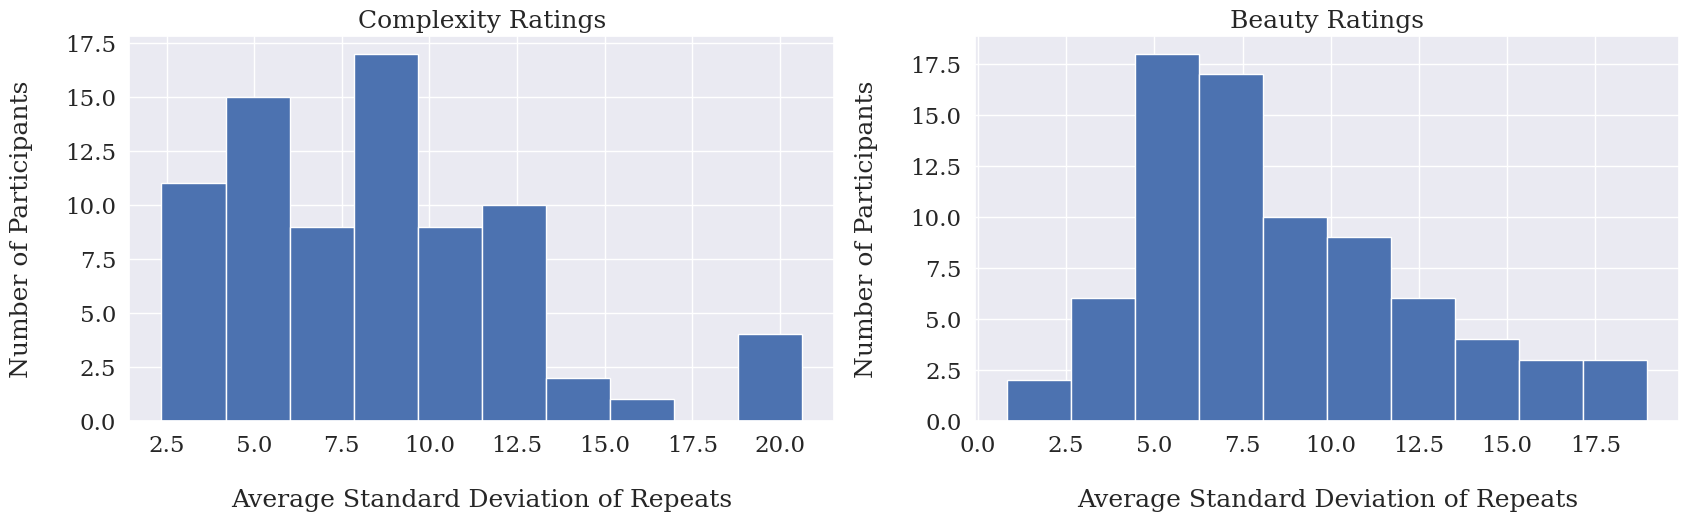

In [14]:
# Figure AIII.3
# Plot histogram of participant mean standard deviation of repeats

fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].hist(participant_repeats_complexity_sd)
ax[0].set_xlabel("\nAverage Standard Deviation of Repeats")
ax[0].set_ylabel("Number of Participants\n")
ax[0].set_title("Complexity Ratings")

ax[1].hist(participant_repeats_beauty_sd)
ax[1].set_xlabel("\nAverage Standard Deviation of Repeats")
ax[1].set_ylabel("Number of Participants\n")
ax[1].set_title("Beauty Ratings")

plt.savefig("plots/Figure_AIII_3_repeatsconsistency.png", dpi=700)
plt.show()

### Test-retest Correlations - Figure AIII.4

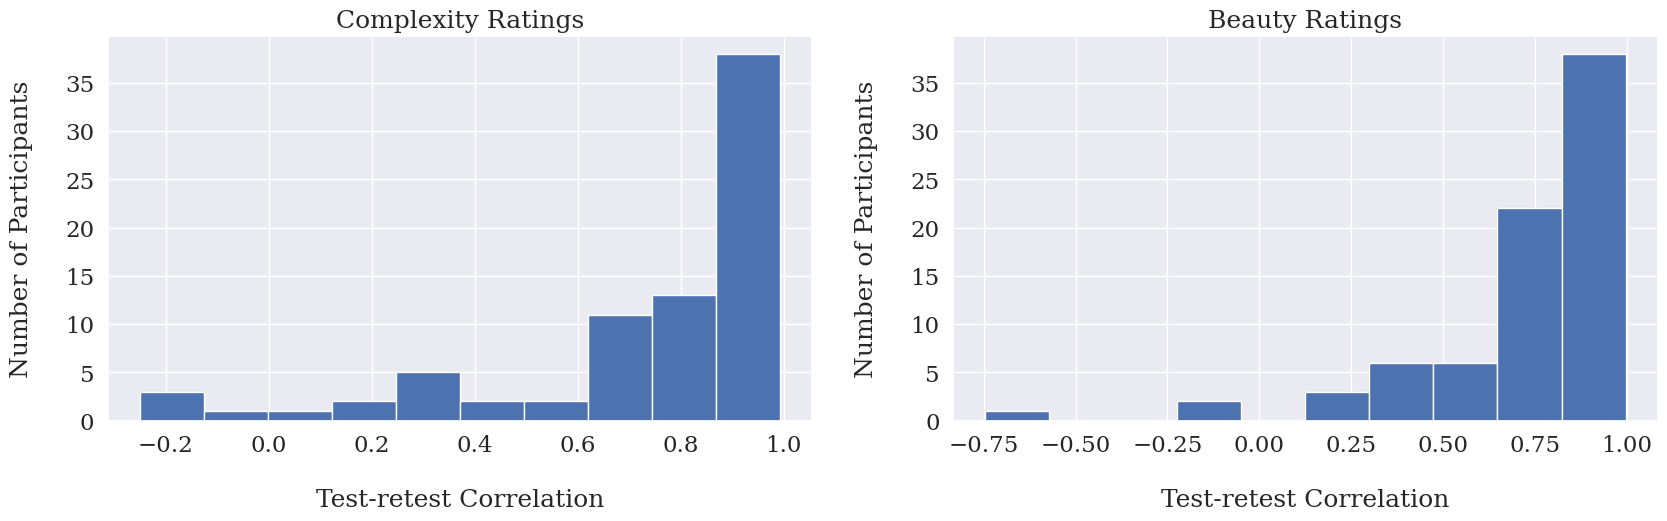

In [15]:
# Figure AIII.4
# plot histogram of participant test-retest correlations

firstrepeat_complexity = np.array(firstrepeat_complexity)
secondrepeat_complexity = np.array(secondrepeat_complexity)
firstrepeat_beauty = np.array(firstrepeat_beauty)
secondrepeat_beauty = np.array(secondrepeat_beauty)

mean_ppt_corr_complexity = []
for pair in zip(firstrepeat_complexity, secondrepeat_complexity):
    mean_ppt_corr_complexity.append(np.corrcoef(pair[0], pair[1])[0,1])

mean_ppt_corr_beauty = []
for pair in zip(firstrepeat_beauty, secondrepeat_beauty):
    mean_ppt_corr_beauty.append(np.corrcoef(pair[0], pair[1])[0,1])

fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].hist(mean_ppt_corr_complexity)
ax[0].set_xlabel("\nTest-retest Correlation")
ax[0].set_ylabel("Number of Participants\n")
ax[0].set_title("Complexity Ratings")

ax[1].hist(mean_ppt_corr_beauty)
ax[1].set_xlabel("\nTest-retest Correlation")
ax[1].set_ylabel("Number of Participants\n")
ax[1].set_title("Beauty Ratings")

plt.savefig("plots/Figure_AIII_4_repeatcorr.png", dpi=700)
plt.show()

## Max Discrepancy - Figure 8

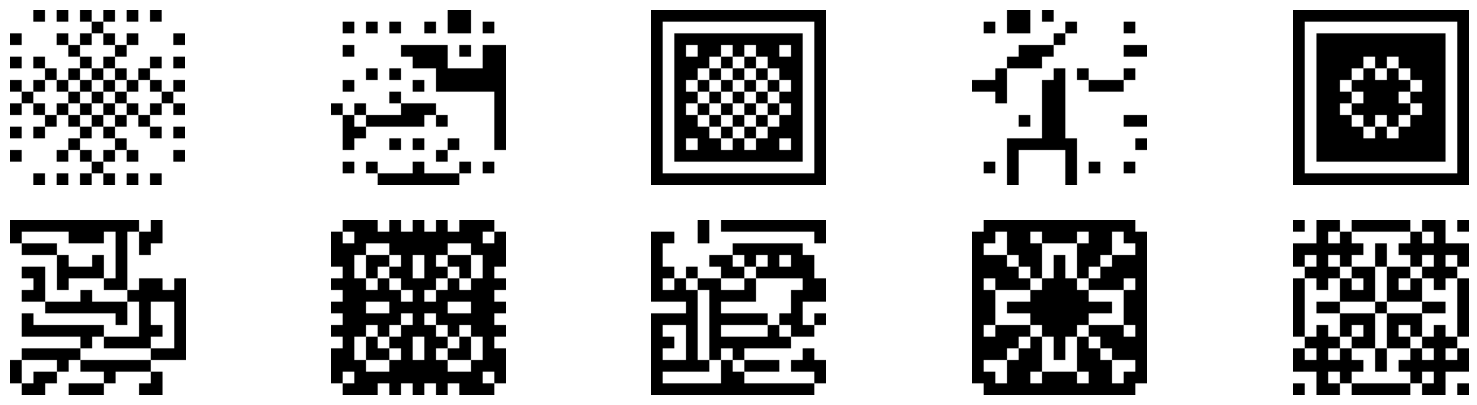

In [16]:
# Figure 8
# Display some of the patterns having max discrepancy in the objective complexity measure and mean subjective complexity ratings 
max_discrepancy_pattnnums = [66,  195, 92,  180, 81, \
                             203, 23, 204, 190, 207] # list of pattern numbers from MixedEffectsModelling.R
max_discrepancy_patterns = np.vectorize(num_to_pattern.get)(max_discrepancy_pattnnums) # get corresponding patterns

fig, ax = plt.subplots(2, 5, figsize=(20,5))
for ind, pattern in enumerate(max_discrepancy_patterns):
    image = plt.imread(patterns_path + pattern)
    ax[ind//5,ind%5].imshow(image)
    ax[ind//5,ind%5].axis('off')
plt.savefig("plots/Figure_8_maxdisc.png", dpi=700)
plt.show()

## Pattern Visualisation - Figure 6

In [17]:
to_display = 5 # number of patterns to visualise

In [18]:
# Calculate patternwise rating mean and variance
mean_pattern_complexity_ratings = df_patternwisemean["complexity_rating"].to_numpy()
mean_pattern_beauty_ratings = df_patternwisemean["beauty_rating"].to_numpy()
sd_pattern_complexity_ratings = df_patternwisesd["complexity_rating"].to_numpy()
sd_pattern_beauty_ratings = df_patternwisesd["beauty_rating"].to_numpy()

### Average response - Figure 6A-D

In [19]:
high_complexities = mean_pattern_complexity_ratings[np.argsort(mean_pattern_complexity_ratings)[-to_display:]] # get the highest average complexity ratings
high_complexities_sd = sd_pattern_complexity_ratings[np.argsort(mean_pattern_complexity_ratings)[-to_display:]] # get the standard deviations of the ratings for the patterns with highest average complexity ratings
high_complex_patternnums = np.argsort(mean_pattern_complexity_ratings)[-to_display:] + 1 # get the patternnums with highest average complexity ratings (convert numpy indexing to pattern num with + 1)
high_complex_patterns = np.vectorize(num_to_pattern.get)(high_complex_patternnums) # get corresponding pattern names

low_complexities = mean_pattern_complexity_ratings[np.argsort(mean_pattern_complexity_ratings)[:to_display]] # get the lowest average complexity ratings
low_complexities_sd = sd_pattern_complexity_ratings[np.argsort(mean_pattern_complexity_ratings)[:to_display]] # get the standard deviations of the ratings for the patterns with lowest average complexity ratings
low_complex_patternnums = np.argsort(mean_pattern_complexity_ratings)[:to_display] + 1 # get the patternnums with lowest average complexity ratings (convert numpy indexing to pattern num with + 1)
low_complex_patterns = np.vectorize(num_to_pattern.get)(low_complex_patternnums) # get corresponding pattern names

high_beauties = mean_pattern_beauty_ratings[np.argsort(mean_pattern_beauty_ratings)[-to_display:]] # get the highest average beauty ratings
high_beauties_sd = sd_pattern_complexity_ratings[np.argsort(mean_pattern_beauty_ratings)[-to_display:]] # get the standard deviations of the ratings for the patterns with highest average beauty ratings
high_beauty_patternnums = np.argsort(mean_pattern_beauty_ratings)[-to_display:] + 1 # get the patternnums with highest average beauty ratings (convert numpy indexing to pattern num with + 1)
high_beauty_patterns = np.vectorize(num_to_pattern.get)(high_beauty_patternnums) # get corresponding pattern names

low_beauties = mean_pattern_beauty_ratings[np.argsort(mean_pattern_beauty_ratings)[:to_display]] # get the lowest average beauty ratings 
low_beauties_sd = sd_pattern_complexity_ratings[np.argsort(mean_pattern_beauty_ratings)[:to_display]] # get the standard deviations of the ratings for the patterns with lowest average beauty ratings
low_beauty_patternnums = np.argsort(mean_pattern_beauty_ratings)[:to_display] + 1 # get the patternnums with lowest average beauty ratings (convert numpy indexing to pattern num with + 1)
low_beauty_patterns = np.vectorize(num_to_pattern.get)(low_beauty_patternnums) # get corresponding pattern names

#### High Complexity - Figure 6A

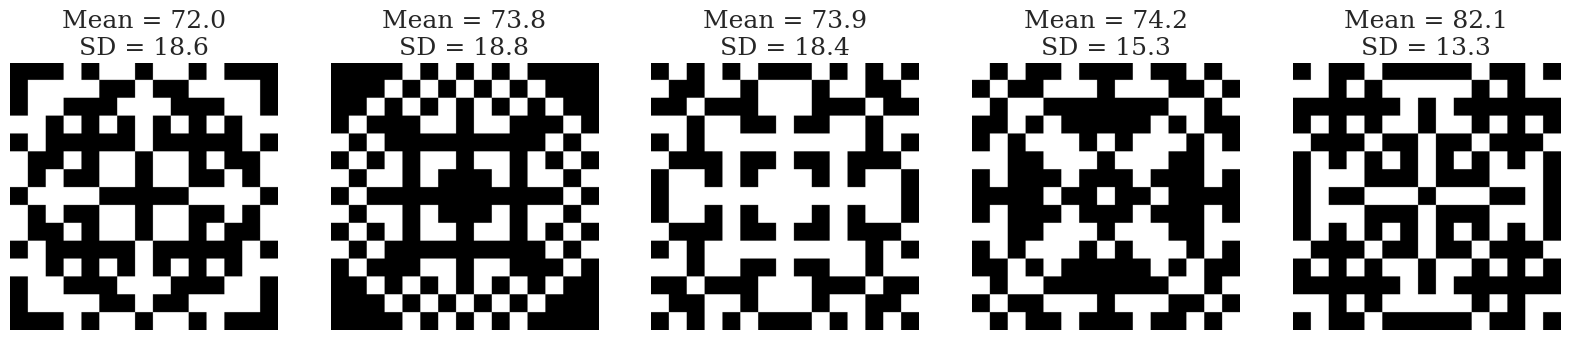

In [20]:
# Figure 6A
# The title for each plot is the mean complexity rating
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + high_complex_patterns[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(high_complexities[i],1)) + "\n" + "SD = " + str(np.round(high_complexities_sd[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6A_highcomplexity.png", dpi=700)
plt.show()

#### Low Complexity - Figure 6B

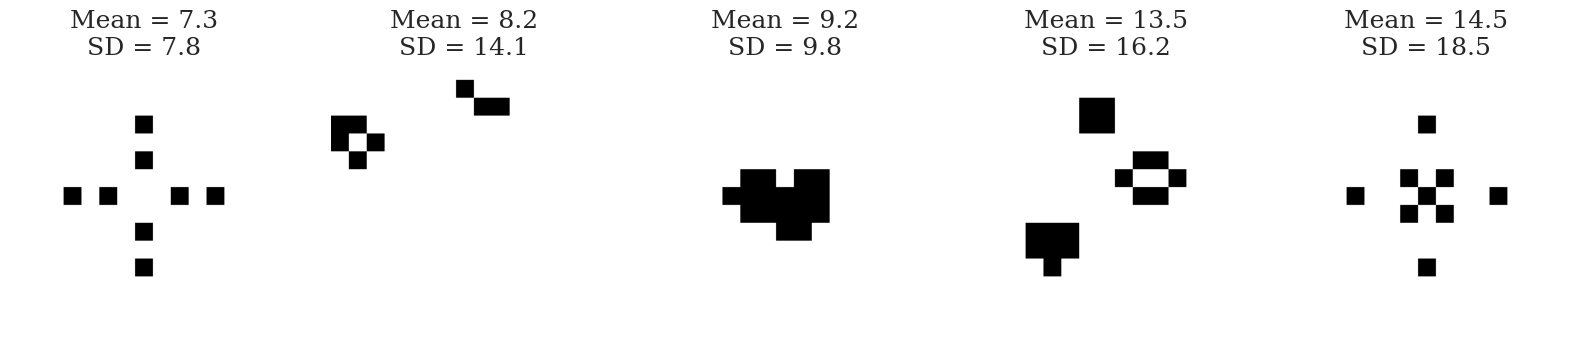

In [21]:
# Figure 6B
# The title for each plot is the mean complexity rating
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + low_complex_patterns[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(low_complexities[i],1)) + "\n" + "SD = " + str(np.round(low_complexities_sd[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6B_lowcomplexity.png", dpi=700)
plt.show()

#### High Beauty - Figure 6C

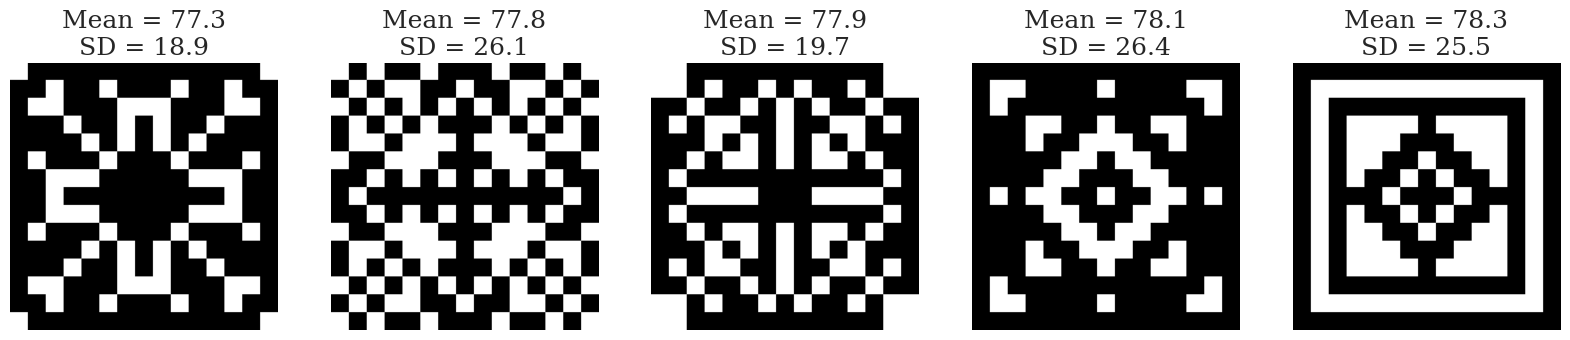

In [22]:
# Figure 6C
# The title for each plot is the mean beauty rating
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + high_beauty_patterns[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(high_beauties[i],1)) + "\n" + "SD = " + str(np.round(high_beauties_sd[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6C_highbeauty.png", dpi=700)
plt.show()

#### Low Beauty - Figure 6D

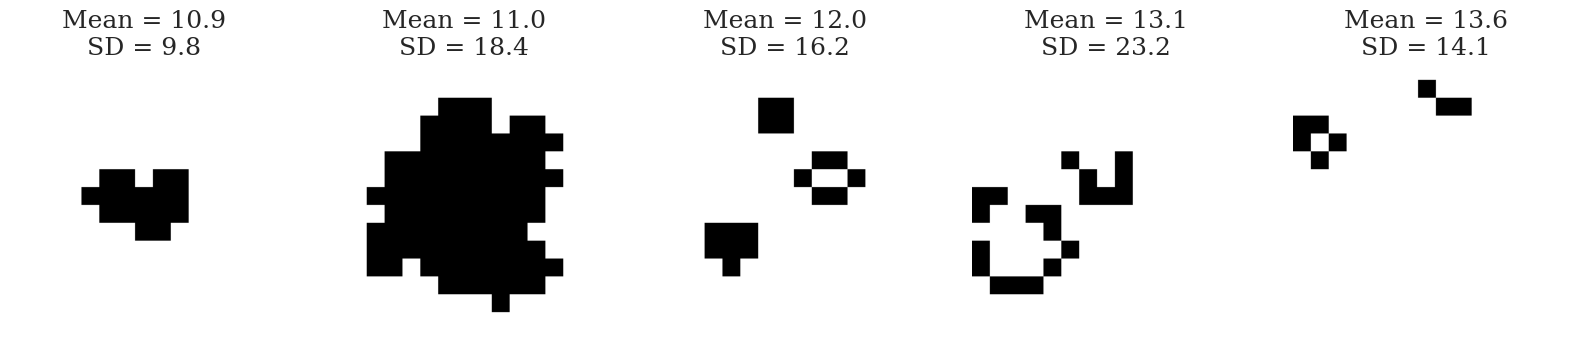

In [23]:
# Figure 6D
# The title for each plot is the mean beauty rating
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + low_beauty_patterns[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(low_beauties[i],1)) + "\n" + "SD = " + str(np.round(low_beauties_sd[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6D_lowbeauty.png", dpi=700)
plt.show()

### Variance in Responses - Figure 6E-H

In [24]:
# consistent patterns are the ones with lowest variance in ratings
# confusing patterns are the ones with highest variance in ratings

confusing_complexities = sd_pattern_complexity_ratings[np.argsort(sd_pattern_complexity_ratings)[-to_display:]] # get the highest variance complexity ratings
confusing_complexities_mean = mean_pattern_complexity_ratings[np.argsort(sd_pattern_complexity_ratings)[-to_display:]] # get the mean rating for the patterns with highest standard deviation in complexity ratings
confusing_patternnums_complexity = np.argsort(sd_pattern_complexity_ratings)[-to_display:] + 1 # get the patternnums with highest variance complexity ratings (convert numpy indexing to pattern num with + 1)
confusing_patterns_complexity = np.vectorize(num_to_pattern.get)(confusing_patternnums_complexity) # get corresponding pattern names

consistent_complexities = sd_pattern_complexity_ratings[np.argsort(sd_pattern_complexity_ratings)[:to_display]] # get the lowest variance complexity ratings
consistent_complexities_mean = mean_pattern_complexity_ratings[np.argsort(sd_pattern_complexity_ratings)[:to_display]] # get the mean rating for the patterns with lowest standard deviation in complexity ratings
consistent_patternnums_complexity = np.argsort(sd_pattern_complexity_ratings)[:to_display] + 1 # get the patternnums with lowest variance complexity ratings (convert numpy indexing to pattern num with + 1)
consistent_patterns_complexity = np.vectorize(num_to_pattern.get)(consistent_patternnums_complexity) # get corresponding pattern names

confusing_beauties = sd_pattern_beauty_ratings[np.argsort(sd_pattern_beauty_ratings)[-to_display:]] # get the highest variance beauty ratings
confusing_beauties_mean = mean_pattern_beauty_ratings[np.argsort(sd_pattern_beauty_ratings)[-to_display:]] # get the mean rating for the patterns with highest standard deviation in beauty ratings
confusing_patternnums_beauty = np.argsort(sd_pattern_beauty_ratings)[-to_display:] + 1 # get the patternnums with highest variance beauty ratings (convert numpy indexing to pattern num with + 1)
confusing_patterns_beauty = np.vectorize(num_to_pattern.get)(confusing_patternnums_beauty) # get corresponding pattern names

consistent_beauties = sd_pattern_beauty_ratings[np.argsort(sd_pattern_beauty_ratings)[:to_display]] # get the lowest variance beauty ratings 
consistent_beauties_mean = mean_pattern_beauty_ratings[np.argsort(sd_pattern_beauty_ratings)[:to_display]] # get the mean rating for the patterns with lowest standard deviation in beauty ratings
consistent_patternnums_beauty = np.argsort(sd_pattern_beauty_ratings)[:to_display] + 1 # get the patternnums with lowest variance beauty ratings (convert numpy indexing to pattern num with + 1)
consistent_patterns_beauty = np.vectorize(num_to_pattern.get)(consistent_patternnums_beauty) # get corresponding pattern names

#### Consistent Patterns Complexity - Figure 6E

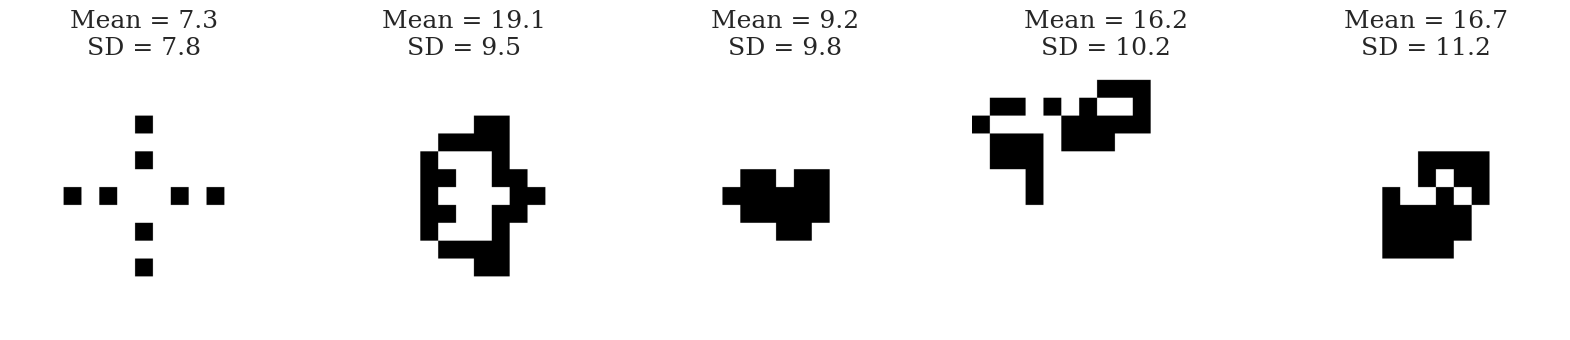

In [25]:
# Figure 6E
# The title for each plot is the var in complexity ratings
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + consistent_patterns_complexity[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(consistent_complexities_mean[i],1)) + "\n" + "SD = " + str(np.round(consistent_complexities[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6E_consistentcomplexity.png", dpi=700)
plt.show()

#### Confusing Patterns Complexity - Figure 6F

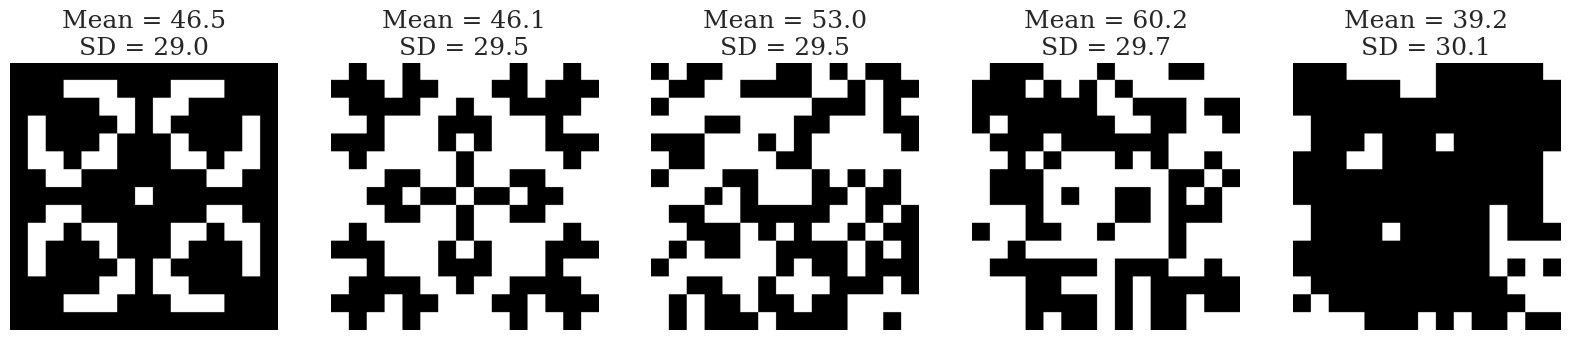

In [26]:
# Figure 6F
# The title for each plot is the var in complexity ratings
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + confusing_patterns_complexity[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(confusing_complexities_mean[i],1)) + "\n" + "SD = " + str(np.round(confusing_complexities[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6F_confusingcomplexity.png", dpi=700)
plt.show()

#### Consistent Patterns Beauty - Figure 6G

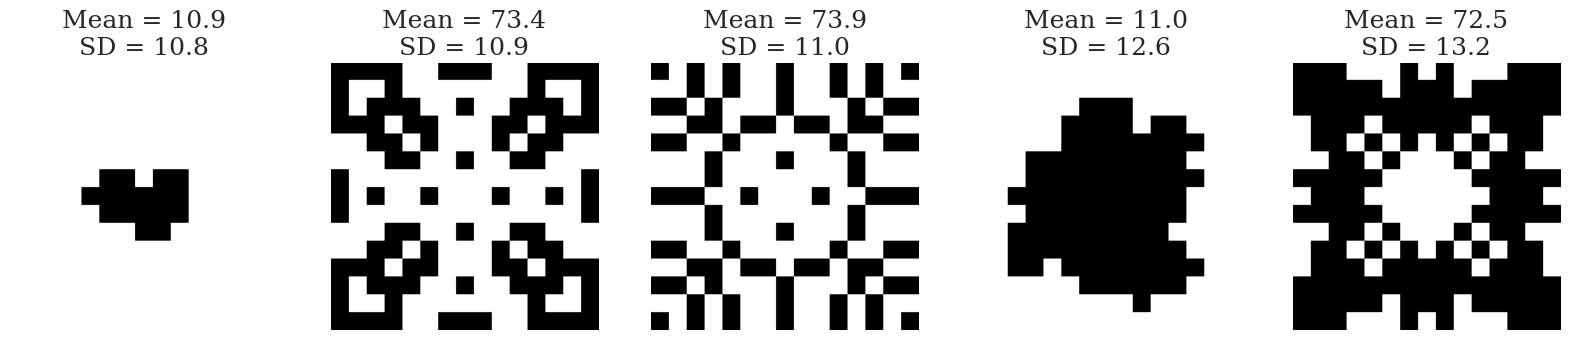

In [27]:
# Figure 6G
# The title for each plot is the var in beauty ratings
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + consistent_patterns_beauty[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(consistent_beauties_mean[i],1)) + "\n" + "SD = " + str(np.round(consistent_beauties[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6G_consistentbeauty.png", dpi=700)
plt.show()

#### Confusing Patterns Beauty - Figure 6H

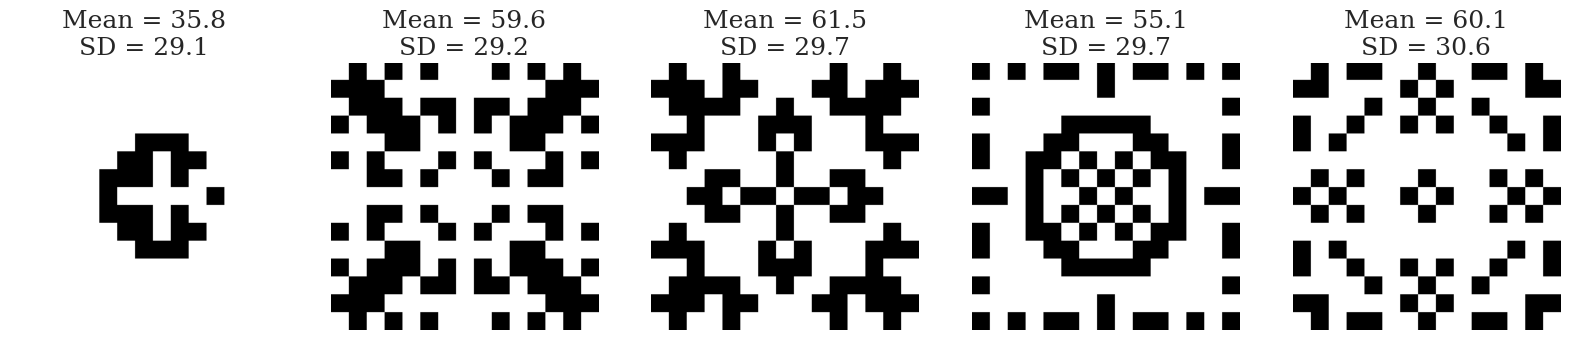

In [28]:
# Figure 6H
# The title for each plot is the var in beauty ratings
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(to_display):
    image = plt.imread(patterns_path + confusing_patterns_beauty[i])
    ax[i].imshow(image)
    ax[i].set_title("Mean = " + str(np.round(confusing_beauties_mean[i],1)) + "\n" + "SD = " + str(np.round(confusing_beauties[i],1)))
    ax[i].axis('off')
plt.savefig("plots/Figure_6H_confusingbeauty.png", dpi=700)
plt.show()